In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque


# Softmax-Q policy

In [2]:
from agents import Agent
from evaluation import get_util
from human_model import *
from model_utils import *
from policies import RandomPolicy, FixedPlanPolicy, LiederPolicy

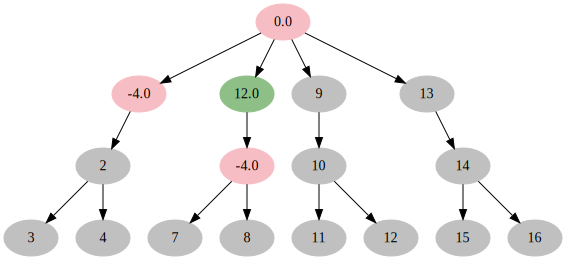

In [69]:
env = make_env(1.25)
env.reset()
for a in [1, 5, 6,]:
    env.step(a)
env.render()

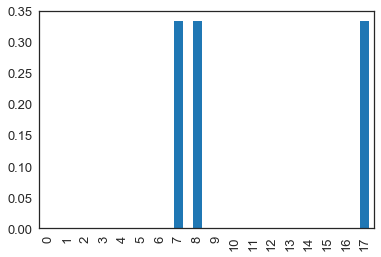

In [73]:
from human_model import *
agent = Agent()
theta = [1, 0, 0]
pol = HumanPolicy(theta=theta, temp=0.1, aggregate=True)
agent.register(env)
agent.register(pol)
pd.Series(pol.action_distribution(env._state)).plot.bar()

# Simulate experiment

In [6]:
from analysis_utils import *
df, pdf = load('1.8', base='exp-data')
COSTS = pdf.info_cost.unique()

def load_envs():
    envs = {}
    for cost in pdf.info_cost.unique():
        with open(f'exp-data/rewards_{cost:.2f}.json') as f:
            d = json.load(f)
            for trial in concatv(d['train'], d['test']):
                envs[trial['trial_id']] = make_env(cost, ground_truth=trial['stateRewards'])
    return envs
    
envs = load_envs()

In [ ]:
cost = 1.25
from human_model import *
pol, result = HumanPolicy.optimize([env] * 100, n_calls=100, aggregate=False)

In [ ]:
label = Labeler()
def simulate(policy, envs, seed='-1'):
    agent = Agent()
    agent.register(ENV)
    agent.register(policy)
    for trial_id, env in envs.items():
        agent.register(env)
        trace = agent.run_episode()
        for s, a in zip(trace['states'], trace['actions']):
            yield {'pid': seed, 'cost': abs(env.cost), 'trial_id': trial_id,
                   'state': label(s), 'action': a}
            


# sdf = pd.DataFrame(list(concat(simulate(pol, envs, seed) 
#                           for seed, pol in zip(range(5), results))))
alt_envs = dict(zip(range(100), make_envs(1.25, ground_truth=1)))
sdf = pd.DataFrame(simulate(results[0], alt_envs))

# Fit human data

In [ ]:
from analysis_utils import load
from model_utils import *
from toolz import *
from human_model import action_features

label = Labeler()
def expand():
    for i, row in df.iterrows():
        for s, a in zip(row.states, concatv(row.clicks, [ENV.term_action])):
            yield {'pid': row.pidx, 'cost': row.info_cost, 'pr_type': row.pr_type,
                   'state': label(parse_state(s)), 'action': a, 'trial_id': row.trial_id}

data = pd.DataFrame(expand())
data.head()

Likelihood:
$$p(D \mid \theta) = \prod_i^N p(a_i \mid s_i; \theta)$$

Softmax Q policy:
$$p(a \mid s; \theta) = \frac{\exp \{ Q(s, a; \theta) \} }{ \sum_{a'} \exp \{ Q(s, a'; \theta) \} }$$

Linear regression Q:
$$Q(s, a; \theta) = \theta^\top \phi(s, a)$$

Before performing inference, we precompute the features, storing them in a 3d tensor.
`phi[s, a, f]` will give the value $\phi(s, a)_f$


In [ ]:
phi = np.array([[action_features(env, s, a) for a in range(env.term_action + 1)]
                 for s in label._xs])


In [ ]:
def logp(data, theta, temp=1):
    Q = np.dot(phi[data.state.as_matrix()], theta)
    idx = np.arange(len(data))
    eq = np.exp(Q / temp)
    chosen = eq[idx, data.action.as_matrix()]
    return np.log(chosen / (eq.sum(1) + 1e-10)).sum()
    
# print(logp(np.r_[1, trace['theta'].mean(0)]))
print(logp(data.query('pid == 1'), results[0].theta))

In [ ]:
import pymc3 as pm
import theano.tensor as tt

def run_model(data):
    n_pid = data.pid.max() + 1
    n_feature = len(phi[0,0])
    idx = np.arange(len(data))

    with pm.Model() as model:

        theta = pm.Normal('theta', 0, 5, shape=n_feature-1)
        temp = 1
        Q = tt.dot(phi[data.state.as_matrix()], tt.concatenate([[1], theta]))
        Q = Q - Q.max(1).reshape((len(data), 1))  # numerical stability
        eq = tt.exp(Q / temp)
        chosen = eq[idx, data.action.as_matrix()]
        likelihood = pm.Deterministic('likelihood', chosen / (eq.sum(1) + 1e-10))
        pm.Potential('logp', np.log(likelihood).sum())

        return pm.sample(njobs=10), model

trace, model = run_model(sdf)
    

In [ ]:
pm.traceplot(trace)

In [ ]:
inferred_pol = HumanPolicy(np.r_[1, trace['theta'].mean(0)])
print(inferred_pol.theta)
print(results[0].theta)

In [ ]:
pm.summary(trace)